In [15]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [17]:
model = "LinearNoInt"
mode = "MeanSubFiringRate"
alpha = 0.01

def get_results(session): 
    res_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat.pickle"
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID

    shuffle_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat_shuffles.pickle"
    shuffles = pd.read_pickle(os.path.join(OUTPUT_DIR, shuffle_name))
    # sig_bounds = shuffles.groupby("split_idx").apply(lambda group: glm_utils.calculate_sig_stats(group, alpha, 1, "score")).reset_index()
    sig_bounds = glm_utils.calculate_sig_stats(shuffles, alpha, 1, "score")

    merged = pd.merge(res, sig_bounds, on=["UnitID"])
    return merged
# sig = glm_utils.calculate_sig_stats(shuffles, )
# return res
# glm_res = pd.concat(sessions.apply(lambda x: get_agg_glm_res(x.session_name), axis=1).values)

In [18]:
glm_res = pd.concat(sessions.apply(lambda x: get_results(x.session_name), axis=1).values)
positions = spike_utils.get_unit_positions(sessions)
glm_res = pd.merge(positions, glm_res, on="PseudoUnitID")

In [19]:
good_reses = glm_res[(glm_res.score > glm_res.sig_bound)]
good_reses = good_reses.sort_values(by="score", ascending=False)

In [20]:
good_reses.groupby("session_x").PseudoUnitID.nunique()

session_x
20180705        1
20180709        1
201807250001    1
20180801        4
20180802        1
20180803        1
20180912        1
20180924        2
20181004        1
Name: PseudoUnitID, dtype: int64

In [7]:
len(good_reses)

52

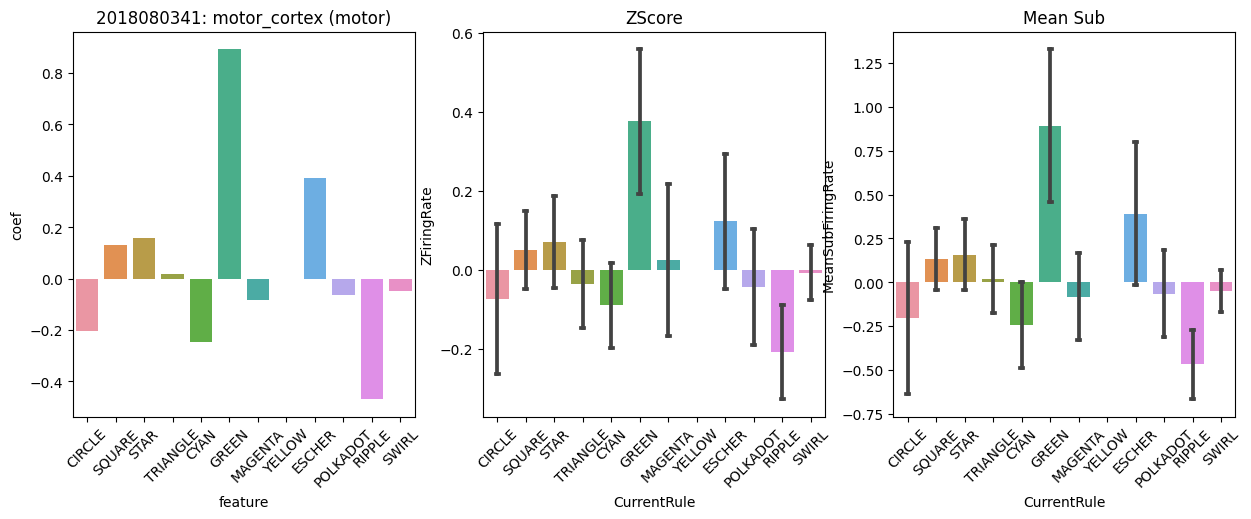

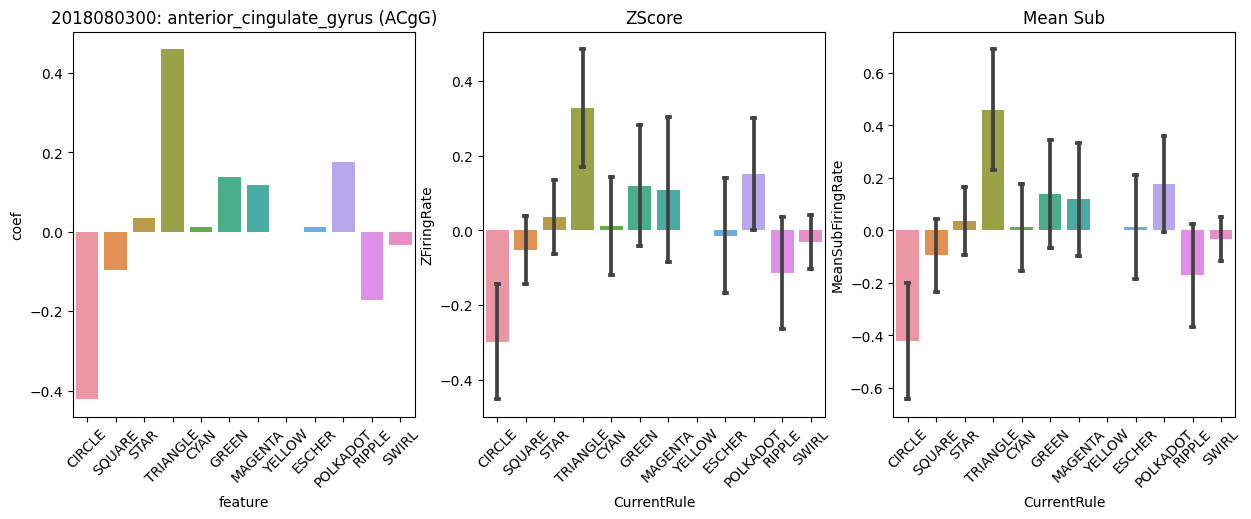

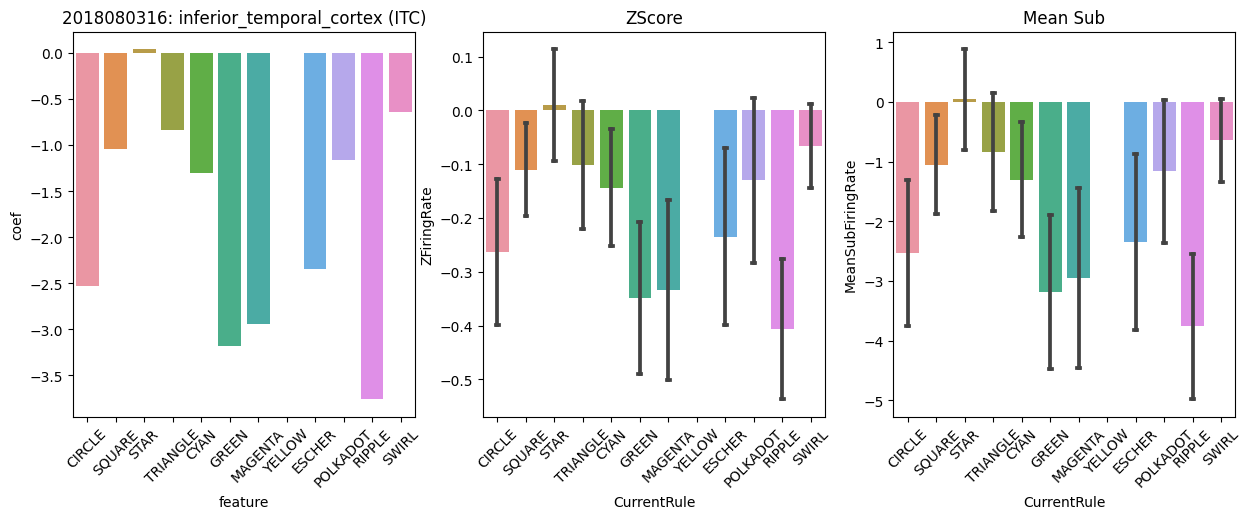

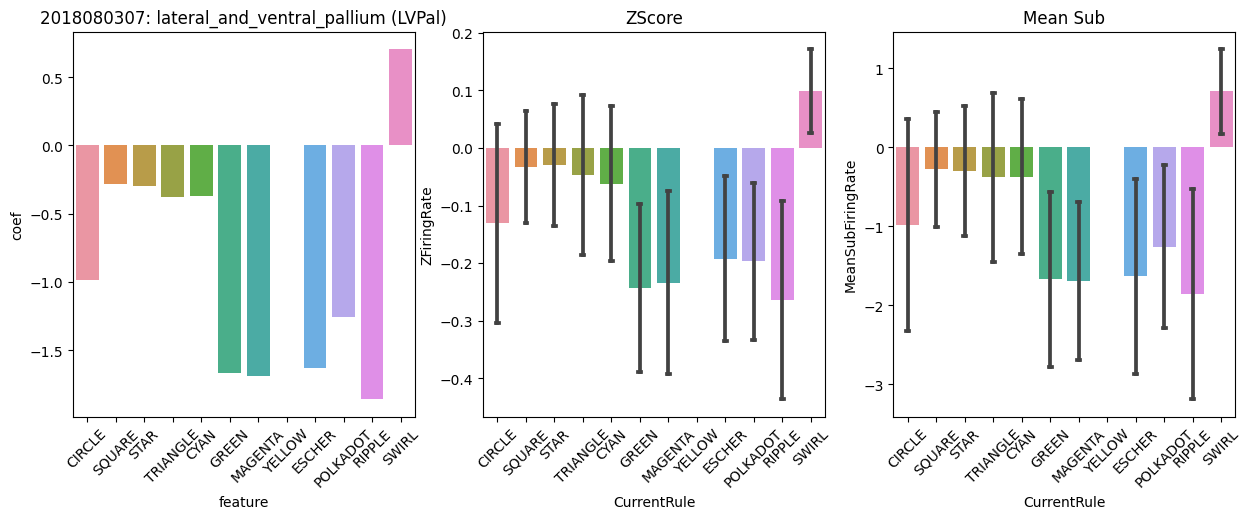

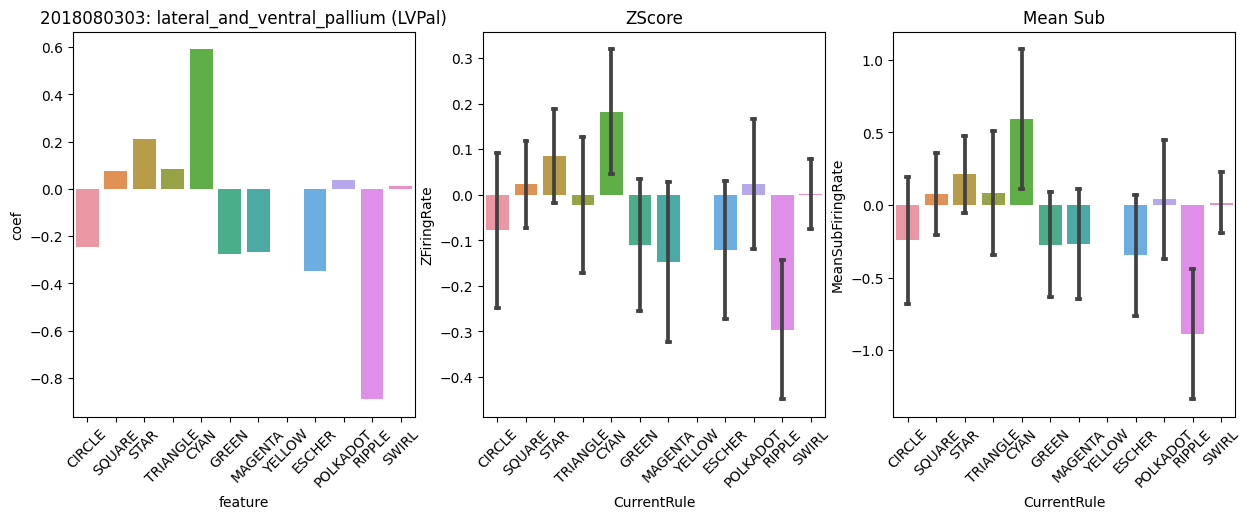

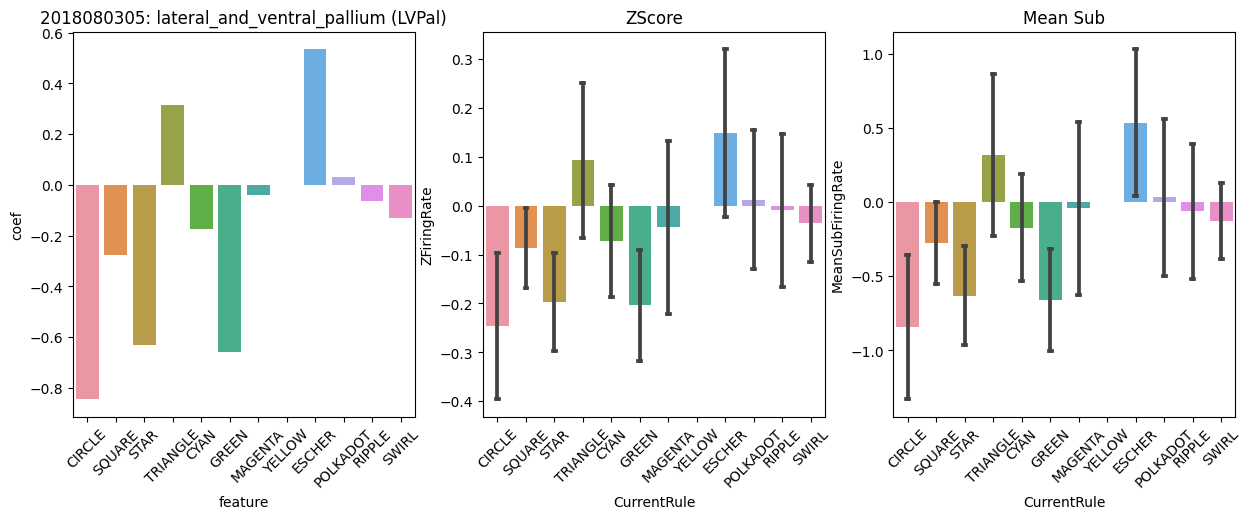

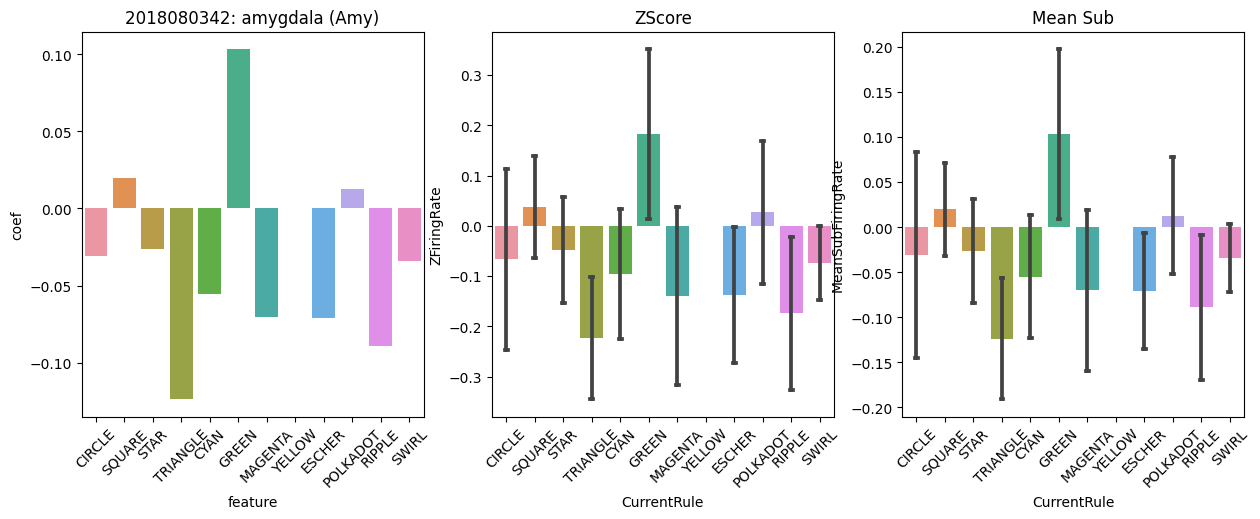

In [14]:
# for unit in [2018091204]:
# reg_units = good_reses[good_reses.structure_level2 == "lateral_and_ventral_pallium (LVPal)"]
# for unit in reg_units.PseudoUnitID.unique():
for unit in good_reses[good_reses.session_x == "20180803"].PseudoUnitID.unique():
    unit_res = glm_res[glm_res.PseudoUnitID == unit]
    session = unit_res.iloc[0].session_x
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber")
    beh = behavioral_utils.get_feature_values_per_session(session, beh)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == unit_res.iloc[0].UnitID_x]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    agg = pd.merge(beh[["TrialNumber", "BlockNumber", "CurrentRule"]], agg, on="TrialNumber")
    agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
    agg = spike_utils.mean_sub_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)

    beh = behavioral_utils.filter_blocks_by_rule_occurence(beh, 2)
    beh = behavioral_utils.filter_max_feat_correct(beh)

    agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]

    rename_map = {f"{feat}_coef": feat for feat in FEATURES}
    unit_res = unit_res.rename(columns=rename_map)
    melted = pd.melt(unit_res, value_vars=FEATURES, var_name="feature", value_name="coef")

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    ax = axs[0]
    visualization_utils.plot_bars_by_cat(melted, "coef", "feature", ax, order=FEATURES)
    ax.set_title(f"{unit}: {unit_res.iloc[0].structure_level2}")

    ax = axs[1]
    visualization_utils.plot_bars_by_cat(agg, "ZFiringRate", "CurrentRule", ax, order=FEATURES)
    ax.set_title("ZScore")

    ax = axs[2]
    visualization_utils.plot_bars_by_cat(agg, "MeanSubFiringRate", "CurrentRule", ax, order=FEATURES)
    ax.set_title("Mean Sub")


### Try to figure out what's going on with GLM fitting

In [65]:
session = 20180912
unit_id = 4
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber")
beh = behavioral_utils.get_feature_values_per_session(session, beh)

fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"
frs = pd.read_pickle(fr_path)
frs = frs[frs.UnitID == unit_id]
agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
# agg = pd.merge(beh[["TrialNumber", "BlockNumber", "MaxFeat"]], agg, on="TrialNumber")
agg = pd.merge(beh[["TrialNumber", "BlockNumber"]], agg, on="TrialNumber")

agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
agg = spike_utils.mean_sub_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)

beh = behavioral_utils.filter_blocks_by_rule_occurence(beh, 2)
beh = behavioral_utils.filter_max_feat_correct(beh)

agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]

In [67]:
input_columns = ["MaxFeat"]
columns_to_flatten = ["MaxFeat"]
beh = beh.set_index(["TrialNumber"])
agg = agg.set_index(["TrialNumber"])
all_reses = glm_utils.fit_glm_for_data(
    (beh, agg), 
    input_columns=input_columns, 
    columns_to_flatten=columns_to_flatten,
    mode="MeanSubFiringRate",
    model_type="LinearNoInt",
)

Index(['MaxFeat', 'BlockNumber', 'UnitID', 'TimeBins', 'SpikeCounts',
       'FiringRate', 'ZFiringRate', 'MeanSubFiringRate'],
      dtype='object')
MeanSubFiringRate
MeanSubFiringRate
(457, 7)
(457,)
[-0.09057875  0.07330057 -0.07226375 -0.07739352 -0.26055128 -0.06745858
 -0.15584416]


In [49]:
all_reses

,UnitID,TimeBins,score,RIPPLE_coef,SWIRL_coef,ESCHER_coef,YELLOW_coef,MAGENTA_coef,GREEN_coef,CYAN_coef
0,4,0.475,0.085783,0.242424,1.189189,0.837838,0.671533,0.513889,0.222222,0.793651


In [59]:
input_columns = ["MaxFeat"]
columns_to_flatten = ["MaxFeat"]
not_flattened_columns = [col for col in input_columns if col not in columns_to_flatten]
data, flattened_columns = glm_utils.flatten_columns(agg, columns_to_flatten)
glm_columns = flattened_columns + not_flattened_columns
# res = data.groupby(["UnitID", "TimeBins"]).apply(
#     lambda x: glm_utils.fit_glm(x, glm_columns, mode, model_type, include_predictions, train_test_split)
# ).reset_index()

Index(['TrialNumber', 'BlockNumber', 'MaxFeat', 'UnitID', 'TimeBins',
       'SpikeCounts', 'FiringRate', 'ZFiringRate', 'MeanSubFiringRate'],
      dtype='object')


In [60]:
from sklearn.linear_model import (
    PoissonRegressor,
    LinearRegression,
    Ridge,
)
model = LinearRegression(fit_intercept=False)
ys = data["MeanSubFiringRate"].values
xs = data[glm_columns].values

In [61]:
xs.shape

(457, 7)

<Axes: >

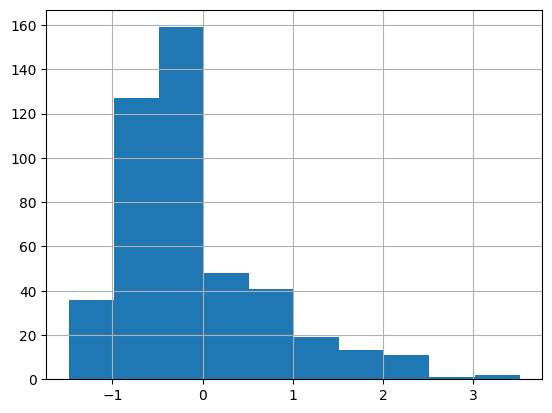

In [25]:
data["MeanSubFiringRate"].hist()

In [63]:
model = model.fit(xs, ys)


In [62]:
ys.shape

(457,)

In [64]:
model.coef_

array([-0.09057875,  0.07330057, -0.07226375, -0.07739352, -0.26055128,
       -0.06745858, -0.15584416])

In [29]:
glm_columns

['RIPPLE', 'SWIRL', 'ESCHER', 'YELLOW', 'MAGENTA', 'GREEN', 'CYAN']

In [36]:
xs.shape

(383, 5)

In [11]:
from numpy.linalg import inv, matrix_rank
# exs = np.hstack((np.ones((383, 1)), xs[:, 1:]))
# exs = np.hstack((np.ones((383, 1)), xs))
exs = xs

beta = inv(exs.T @ exs) @ exs.T @ ys
# beta = inv(xs.T @ xs) @ xs.T @ ys

In [12]:
len(exs[:, 0])

383

In [13]:
beta

array([-0.09057875, -0.07739352, -0.26055128, -0.06745858, -0.15584416])

In [19]:
np.mean(ys[xs[:, 0] == 1])

-0.09057875264270614

In [46]:
-0.09057875 + 0.01318523

-0.07739352